# Bag-of-Words Classifier Pipeline

In [28]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Custom functions 
from utils import print_gridsearch_results, test_on_estimator

RANDOM_STATE = 123

In [27]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

## Data prep

In [2]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

# Where to output predictions on the test_set
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
output_dir = 'predictions'

print("Shape of data\n---------------")
print(f"x_train_df shape: {x_train_df.shape} ")
print(f"x_test_df shape: {x_test_df.shape} ")
print(f"y_train_df shape: {y_train_df.shape} ")

# Get the text as a list of strings
x_train_text = x_train_df['text'].values
x_test_text = x_test_df['text'].values
y_train = y_train_df['is_positive_sentiment'].values

Shape of data
---------------
x_train_df shape: (2400, 2) 
x_test_df shape: (600, 2) 
y_train_df shape: (2400, 1) 


## Dataset Exploration

In [3]:
num_train_samples = x_train_text.shape[0]
num_positive_train_samples = np.count_nonzero(y_train == 1)
fraction_positive_train = float(num_positive_train_samples) / float(num_train_samples)


print(f"Total number of training samples = {num_train_samples}")
print(f"Fraction positive training samples = {fraction_positive_train}")


Total number of training samples = 2400
Fraction positive training samples = 0.5


## Define a stable skf CV-splitter

In [147]:
cv_splitter = sklearn.model_selection.StratifiedKFold(n_splits=4)

## Basic comparison of two vectorizers - one with counts and one using tfidf


In [148]:
count_vectorizer = CountVectorizer(stop_words='english')
# #  Parameters for grid search
# count_parameters = {
#     'count__min_df': np.arange(1, 3),
#     'count__max_df': (0.05, 0.5),
#     'count__ngram_range': [(1, 1), (1, 2)],
# }

# Static Parameters based on earlier grid_search 
count_vectorizer.set_params(min_df = 2, ngram_range = (1,2))


# Set the tuple for the pipeline
# count_pipeline_tuple = ("count", count_vectorizer)


CountVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english')

In [149]:
tf_vectorizer = TfidfVectorizer(stop_words='english')
# #  Parameters for grid search
# tf_parameters = { 
#     'tf__min_df': np.arange(1,3),
#     'tf__max_df': (0.05, 0.5),
#     'tf__ngram_range': [(1, 1), (1, 2)],
# }

# Static Parameters based on earlier grid_search 
tf_vectorizer.set_params(min_df = 2, ngram_range = (1,2))

# Set the tuple for the pipeline
tf_pipeline_tuple = ("tf", tf_vectorizer)


## Random Forest: Hyperparameter search and CV

In [151]:
rf_classifier = RandomForestClassifier(random_state=RANDOM_STATE)
# Random Forest hyperparameter grid
rf_parameters = {
    "rf__max_depth": [5, 25, 125, 565],
    "rf__n_estimators": [20, 100, 500, 1000, 10000],
}
rf_pipeline_tuple = ('rf', rf_classifier)

### Fit on the tfidf_vectorizer

In [153]:
tf_rf_pipeline = Pipeline([
    tf_pipeline_tuple,
    rf_pipeline_tuple,
 ])
tf_rf_full_grid = { 
#     **tf_parameters,
    **rf_parameters
}


tf_rf_grid_searcher = GridSearchCV(
    tf_rf_pipeline, 
    tf_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=4,  
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  6.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=4,
             param_grid={'rf__max_depth': [5, 25, 125, 565],
                         'rf__n_estimators': [20, 100, 500, 1000, 10000]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [154]:
print_gridsearch_results(tf_rf_grid_searcher, list(tf_rf_full_grid.keys()))


Dataframe has shape: (20, 20)
Number of trials used in grid search:  20


,param_rf__max_depth,param_rf__n_estimators,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
18,565,1000,0.991528,0.764167,14.276878,1
19,565,10000,0.991528,0.763750,131.921868,2
17,565,500,0.991528,0.762083,6.218492,3
16,565,100,0.991528,0.761667,1.570737,4
12,125,500,0.945556,0.752500,4.912063,5
14,125,10000,0.945139,0.751250,82.023297,6
13,125,1000,0.945556,0.750417,8.693940,7
11,125,100,0.943056,0.750417,1.086477,7
15,565,20,0.989306,0.747500,0.333921,9
10,125,20,0.936250,0.742500,0.401107,10


In [155]:
tf_rf_grid_searcher.best_params_

{'rf__max_depth': 565, 'rf__n_estimators': 1000}

In [156]:
# tf_rf_grid_searcher.cv_results_

In [157]:
# Plotting the CV results for a gridsearch over one feature

# cv_results = tf_rf_grid_searcher.cv_results_
# # Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# # Plot one
# param = list(rf_parameters.keys())[1]
# param_label = "Number of trees in forest frequency"
# param_values = cv_results[f'param_{param}']


# mean_test_score = cv_results['mean_test_score']
# mean_train_score = cv_results['mean_train_score']
# print(mean_test_score)
# print(mean_train_score)

# # Plot Grid search scores
# _, ax = plt.subplots(1, 1)

# ax.plot(param_values.data, mean_test_score, '-o', label='test set')
# ax.plot(param_values.data, mean_train_score, '-o', label='train set')


# ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
# ax.set_xlabel(param_label, fontsize=16)
# ax.set_ylabel('Balanced Accuracy', fontsize=16)
# ax.legend(loc="best", fontsize=15)
# ax.grid('on')




[20 100 500 1000 10000 20 100 500 1000 10000 20 100 500 1000 10000 20 100
 500 1000 10000]
[20, 100, 500, 1000, 10000]
20
[[0.66083333 0.71458333 0.72708333 0.72291667 0.72208333]
 [0.71333333 0.725      0.72916667 0.72958333 0.73083333]
 [0.7425     0.75041667 0.7525     0.75041667 0.75125   ]
 [0.7475     0.76166667 0.76208333 0.76416667 0.76375   ]]
[[0.73944444 0.80180556 0.80819444 0.80583333 0.80625   ]
 [0.84138889 0.85027778 0.85263889 0.85194444 0.85194444]
 [0.93625    0.94305556 0.94555556 0.94555556 0.94513889]
 [0.98930556 0.99152778 0.99152778 0.99152778 0.99152778]]


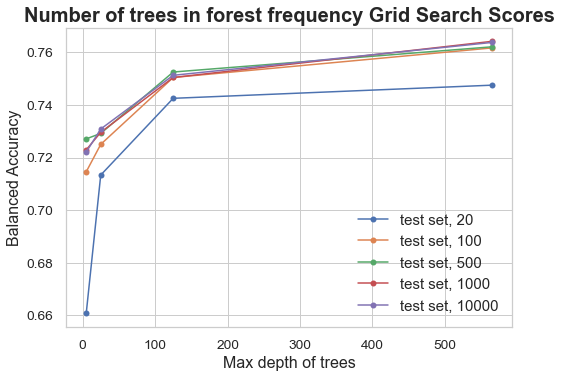

In [158]:
## Failed attempt at blocking each line in the visualization by a second parameter

cv_results = tf_rf_grid_searcher.cv_results_
# Two plots: One comparing train and test performance; one comparing all of the fold scores against one another 
# Plot one
param = list(rf_parameters.keys())[0]
param_label = "Number of trees in forest frequency"
param_values = cv_results[f'param_{param}']
param_range = rf_parameters[param]


second_param = list(rf_parameters.keys())[1]
second_p_label = "Max depth of trees"
second_p_values = cv_results[f'param_{second_param}']
second_p_range = rf_parameters[second_param]
print(second_p_values)
# print(type(second_p_values))
print(second_p_range)
# print(second_p_values == second_p_range[0])


mean_test_score = cv_results['mean_test_score'].reshape(len(param_range), len(second_p_range))
mean_train_score = cv_results['mean_train_score'].reshape(len(param_range), len(second_p_range))
print(mean_test_score)
print(mean_train_score)
_, ax = plt.subplots(1, 1)

for i, val in enumerate(second_p_range): 
    ax.plot(param_range, mean_test_score[:, i], '-o', label=f'test set, {val}')
#     ax.plot(param_range, mean_train_score[:, i], '-o', label=f'train set, {val}')

ax.set_title(f"{param_label} Grid Search Scores", fontsize=20, fontweight='bold')
ax.set_xlabel(second_p_label, fontsize=16)
ax.set_ylabel('Balanced Accuracy', fontsize=16)
ax.legend(loc="best", fontsize=15)
ax.grid('on')





In [ ]:
# np.where(tf_rf_grid_searcher.cv_results_['param_rf__n_estimators'] == 100, tf_rf_grid_searcher.cv_results_['mean_test_score'])

In [ ]:
# tf_rf_grid_searcher.cv_results_['param_rf__n_estimators'] == 100

In [ ]:
# tf_rf_grid_searcher.cv_results_['split1_train_score'][tf_rf_grid_searcher.cv_results_['param_rf__n_estimators'] == 100]

In [ ]:
#Plot two - scores over each fold 
# scores_per_fold_K = []

# _, ax = plt.subplots(1, 1)

# # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
# for fold, scores_ in enumerate(scores_per_fold_K):
#     ax.plot(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

# ax.set_title("Balanced Accuracy", fontsize=20, fontweight='bold')
# ax.set_xlabel(name_param_1, fontsize=16)
# ax.set_ylabel('CV Average Score', fontsize=16)
# ax.legend(loc="best", fontsize=15)
# ax.grid('on')



### Fit on CountVector

In [23]:
count_rf_pipeline = Pipeline([
    count_pipeline_tuple,
    rf_pipeline_tuple,
 ])
count_rf_full_grid = { 
    **count_parameters,
    **rf_parameters
}


count_rf_grid_searcher = GridSearchCV(
    count_rf_pipeline, 
    count_rf_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    return_train_score=True,
    scoring='balanced_accuracy'
)
count_rf_grid_searcher.fit(x_train_text, y_train)

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   25.0s
[Parallel(n_jobs=3)]: Done 252 out of 252 | elapsed:   49.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(stop_words='english')),
                                       ('rf',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=3,
             param_grid={'count__min_df': array([1, 2]),
                         'count__ngram_range': [(1, 1), (1, 2)],
                         'rf__max_depth': [5, 10, 20],
                         'rf__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [24]:
print_gridsearch_results(count_rf_grid_searcher, list(count_rf_full_grid.keys()))

Dataframe has shape: (36, 28)
Number of trials used in grid search:  36


,param_count__min_df,param_count__ngram_range,param_rf__n_estimators,param_rf__max_depth,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
17,1,"(1, 2)",300,20,0.876524,0.767143,0.837929,1
16,1,"(1, 2)",200,20,0.873676,0.766728,0.576524,2
15,1,"(1, 2)",100,20,0.873816,0.765467,0.318968,3
14,1,"(1, 2)",300,10,0.857908,0.763862,0.676434,4
13,1,"(1, 2)",200,10,0.855199,0.763024,0.459837,5
6,1,"(1, 1)",100,20,0.851113,0.761684,0.289146,6
11,1,"(1, 2)",300,5,0.836514,0.759296,0.605566,7
8,1,"(1, 1)",300,20,0.855556,0.759190,0.809340,8
7,1,"(1, 1)",200,20,0.852292,0.758772,0.567307,9
5,1,"(1, 1)",300,10,0.833818,0.758376,0.640886,10


In [100]:
print_gridsearch_results(count_rf_grid_searcher, list(count_rf_full_grid.keys()))

Dataframe has shape: (72, 31)
Number of trials used in grid search:  72


,param_count__min_df,param_count__max_df,param_count__ngram_range,param_rf__n_estimators,param_rf__max_depth,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
42,1,0.5,"(1, 1)",100,20,0.853810,0.765833,0.290650,1
52,1,0.5,"(1, 2)",200,20,0.876310,0.764583,0.784306,2
51,1,0.5,"(1, 2)",100,20,0.877679,0.762083,0.533752,3
49,1,0.5,"(1, 2)",200,10,0.851012,0.762083,0.684137,4
48,1,0.5,"(1, 2)",100,10,0.845714,0.760833,0.324446,5
...,...,...,...,...,...,...,...,...,...
9,1,0.05,"(1, 2)",100,5,0.792083,0.707500,0.254434,68
21,2,0.05,"(1, 1)",100,10,0.802917,0.705833,0.219317,69
27,2,0.05,"(1, 2)",100,5,0.773571,0.702500,0.226318,70
0,1,0.05,"(1, 1)",100,5,0.781369,0.694583,0.235885,71


In [25]:
count_rf_grid_searcher.best_params_

{'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'rf__max_depth': 20,
 'rf__n_estimators': 300}

## Generate predictions using best Random Forest and Count Vectorizer

In [102]:
count_rf_filename = os.path.join(output_dir, 'bow_count_rf_yproba1_test.txt')
test_on_estimator(count_rf_grid_searcher.best_estimator_, x_test_text, count_rf_filename)
tf_rf_filename = os.path.join(output_dir, 'bow_tf_rf_yproba1_test.txt')
test_on_estimator(tf_rf_grid_searcher.best_estimator_, x_test_text, tf_rf_filename)

# Gradient Boosted Tree: Hyperparameter search

**NOTE** Only re-run when necessary. The total run-time for rebuilding these classifiers is roughly 15-30 minutes.

In [29]:
gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=RANDOM_STATE)
# GradientBoosting-Tree hyperparameter grid
gbtree_parameters = {
    "gbtree__n_estimators": [100, 200, 300],
    "gbtree__max_depth": [5, 10, 20],
    "gbtree__min_samples_leaf": [1, 3, 5],
}
gbtree_pipeline_tuple = ('gbtree', gbtree_classifier)


### Fit on the tfidf_vectorizer

In [31]:
tf_gbtree_pipeline = Pipeline([
    tf_pipeline_tuple,
    gbtree_pipeline_tuple,
 ])
tf_gbtree_full_grid = { 
    **tf_parameters,
    **gbtree_parameters
}


tf_gbtree_grid_searcher = GridSearchCV(
    tf_gbtree_pipeline, 
    tf_gbtree_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
tf_gbtree_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   10.0s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed:  6.4min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 11.6min
[Parallel(n_jobs=3)]: Done 1080 out of 1080 | elapsed: 20.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('gbtree',
                                        GradientBoostingClassifier(max_depth=5,
                                                                   random_state=123))]),
             n_jobs=3,
             param_grid={'gbtree__max_depth': [5, 10, 20],
                         'gbtree__min_samples_leaf': [1, 3, 5],
                         'gbtree__n_estimators': [100, 200, 300],
                         'tf__max_df': (0.05, 0.5), 'tf__min_df': array([1, 2]),
                         'tf__ngram_range': [(1, 1), (1, 2)]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [32]:
print_gridsearch_results(tf_gbtree_grid_searcher, list(tf_gbtree_full_grid.keys()))

Dataframe has shape: (216, 26)
Number of trials used in grid search:  216


,param_tf__min_df,param_tf__max_df,param_tf__ngram_range,param_gbtree__n_estimators,param_gbtree__max_depth,param_gbtree__min_samples_leaf,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
20,1,0.5,"(1, 1)",300,5,1,0.941979,0.776667,2.447076,1
12,1,0.5,"(1, 1)",200,5,1,0.923750,0.771667,1.560614,2
92,1,0.5,"(1, 1)",300,10,1,0.996146,0.770833,4.124050,3
22,2,0.5,"(1, 1)",300,5,1,0.947604,0.769583,1.807707,4
84,1,0.5,"(1, 1)",200,10,1,0.995937,0.769583,2.854647,5
...,...,...,...,...,...,...,...,...,...,...
27,2,0.05,"(1, 2)",100,5,3,0.819583,0.683333,0.581437,212
209,1,0.05,"(1, 2)",300,20,5,0.940521,0.683333,11.528023,212
48,1,0.05,"(1, 1)",100,5,5,0.797708,0.680833,0.613226,214
211,2,0.05,"(1, 2)",300,20,5,0.940417,0.680417,4.091111,215


In [34]:
tf_gbtree_grid_searcher.best_params_

{'gbtree__max_depth': 5,
 'gbtree__min_samples_leaf': 1,
 'gbtree__n_estimators': 300,
 'tf__max_df': 0.5,
 'tf__min_df': 1,
 'tf__ngram_range': (1, 1)}

## GBTree: Generate Predictions

In [37]:
gbtree_filename = os.path.join(output_dir, 'bow_tf_gbtree_yproba1_test.txt')
test_on_estimator(tf_gbtree_grid_searcher.best_estimator_, x_test_text, gbtree_filename)

## TBD: Figures

In [26]:
fig, loss_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train log loss' if run_id == 0 else ''
    te_label = 'test log loss' if run_id == 0 else ''
    
    loss_ax.plot(np.log2(size_list), tr_loss_arr[:,run_id], 'bd', label=tr_label)
    loss_ax.plot(np.log2(size_list), te_loss_arr[:,run_id], 'rd', label=te_label)

loss_ax.set_xticks(np.log2(size_list));
loss_ax.set_xticklabels(size_list);
loss_ax.xaxis.grid(False);

loss_ax.set_ylim([0, 0.8]); # Don't touch this please
loss_ax.set_yticks(np.arange(0, 0.8, 0.1));
loss_ax.set_title("Log Loss vs Size")
loss_ax.set_ylabel('log loss');
loss_ax.set_xlabel('size');
loss_ax.legend(loc='upper right');

NameError: name 'plt' is not defined


## L1-Logistic Regression: Hyperparameter Search

In [58]:
lasso = sklearn.linear_model.LogisticRegression(penalty='l1', solver='saga', random_state=RANDOM_STATE)
# logit_lasso hyperparameter grid
lasso_parameters = {
     'lasso__C': np.logspace(-4, 4, 9),
     'lasso__max_iter': [20, 40], # sneaky way to do "early stopping" 
}
lasso_pipeline_tuple = ('lasso', lasso)


### Fit on the tfidf_vectorizer

In [59]:
count_lasso_pipeline = Pipeline([
    count_pipeline_tuple,
    lasso_pipeline_tuple,
 ])
count_lasso_full_grid = { 
    **count_parameters,
    **lasso_parameters
}


count_lasso_grid_searcher = GridSearchCV(
    count_lasso_pipeline, 
    count_lasso_full_grid, 
    cv=cv_splitter, 
    n_jobs=3, 
    verbose=3,
    scoring='balanced_accuracy',
    return_train_score=True
)
count_lasso_grid_searcher.fit(x_train_text, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 143 tasks      | elapsed:   26.3s
[Parallel(n_jobs=3)]: Done 303 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 545 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 720 out of 720 | elapsed:  3.3min finished
/Users/dylanphelan/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('count',
                                        CountVectorizer(stop_words='english')),
                                       ('lasso',
                                        LogisticRegression(penalty='l1',
                                                           random_state=101,
                                                           solver='saga'))]),
             n_jobs=3,
             param_grid={'count__max_df': (0.05, 0.5),
                         'count__min_df': array([1, 2]),
                         'count__ngram_range': [(1, 1), (1, 2)],
                         'lasso__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'lasso__max_iter': [20, 40]},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [60]:
print_gridsearch_results(count_lasso_grid_searcher, list(count_lasso_full_grid.keys()))

Dataframe has shape: (144, 25)
Number of trials used in grid search:  144


,param_count__min_df,param_count__max_df,param_count__ngram_range,param_lasso__C,param_lasso__max_iter,mean_train_score,mean_test_score,mean_fit_time,rank_test_score
84,1,0.5,"(1, 1)",100,20,0.967708,0.797083,0.914771,1
82,1,0.5,"(1, 1)",10,20,0.963646,0.797083,0.749147,1
88,1,0.5,"(1, 1)",10000,20,0.968021,0.796250,0.920900,3
86,1,0.5,"(1, 1)",1000,20,0.967917,0.796250,0.968059,3
104,1,0.5,"(1, 2)",1000,20,0.978958,0.795417,2.858857,5
...,...,...,...,...,...,...,...,...,...
109,2,0.5,"(1, 1)",0.0001,40,0.500000,0.500000,0.027523,97
110,2,0.5,"(1, 1)",0.001,20,0.500000,0.500000,0.029619,97
111,2,0.5,"(1, 1)",0.001,40,0.500000,0.500000,0.027353,97
113,2,0.5,"(1, 1)",0.01,40,0.500000,0.500000,0.030030,97


In [61]:
count_lasso_grid_searcher.best_params_

{'count__max_df': 0.5,
 'count__min_df': 1,
 'count__ngram_range': (1, 1),
 'lasso__C': 10.0,
 'lasso__max_iter': 20}

## L1-Logistic Regression: Generate Predictions

In [62]:
lasso_filename = os.path.join(output_dir, 'bow_count_lasso_yproba1_test.txt')
test_on_estimator(count_lasso_grid_searcher.best_estimator_, x_test_text, lasso_filename)

# Archive: Things We May Need 



In [39]:
# np.argwhere(count_rf_grid_searcher.cv_results_["rank_test_score"] == 1)
# count_rf_grid_searcher.cv_results_["mean_train_score"][29]

In [40]:
# random_forest_grid_searcher.fit(x_train_text_count, y_train)

In [41]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [42]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

### Fit on TFIDF

In [43]:
# random_forest_grid_searcher.fit(x_train_text_tf, y_train)

In [44]:
# random_forest_grid_search_results_df = pd.DataFrame(random_forest_grid_searcher.cv_results_).copy()
# n_trials_grid_search = random_forest_grid_search_results_df.shape[0]

In [45]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# Rearrange row order so it is easy to skim
# random_forest_grid_search_results_df.sort_values(param_keys, inplace=True)
# random_forest_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [56]:
# best_random_forest = random_forest_classifier.set_params(**random_forest_grid_searcher.best_params_)
# best_random_forest.fit(x_train_text_count, y_train)

In [47]:
# # Gradient Boosted Tree classifier with default values
# gbtree_classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5, min_samples_leaf=1, random_state=100)

In [48]:
# # Gradient Boosted Tree hyperparameter grid
# gbtree_parameter_grid = dict(
#     n_estimators = [20, 50, 100],
#     max_depth = [5, 10],
#     #min_samples_leaf = [1, 3, 5],
#     #random_state=[101, 202],  # try two possible seeds to initialize parameters
#     random_state=[100],
#     )

In [49]:
# gbtree_grid_searcher = sklearn.model_selection.GridSearchCV(
#     gbtree_classifier,
#     gbtree_parameter_grid,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [50]:
# gbtree_grid_searcher.fit(x_train_text_count, y_train)

In [51]:
# gbtree_grid_search_results_df = pd.DataFrame(gbtree_grid_searcher.cv_results_).copy()
# n_trials_grid_search = gbtree_grid_search_results_df.shape[0]

In [52]:
# param_keys = ['param_n_estimators', 'param_max_depth']

# # Rearrange row order so it is easy to skim
# gbtree_grid_search_results_df.sort_values(param_keys, inplace=True)

In [53]:
# gbtree_grid_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [54]:
# best_gbtree = gbtree_classifier.set_params(**gbtree_grid_searcher.best_params_)
# best_gbtree.fit(x_train_text_count, y_train)

In [63]:
# best_gbtree_yhat_test = best_gbtree.predict(x_test_text_count)
# with open('bow_gbtree_countvectorizer_test_preds.txt', 'w') as f:
#     for pred in best_gbtree_yhat_test:
#         f.write(str(pred) + '\n')

In [64]:
# lasso = sklearn.linear_model.LogisticRegression(
#     penalty='l1', solver='saga', random_state=101)

In [65]:
# lasso_hyperparameter_grid_by_name = dict(
#     C=np.logspace(-4, 4, 9),
#     max_iter=[20, 40], # sneaky way to do "early stopping" 
#                        # we'll take either iter 20 or iter 40 in training process, by best valid performance
#     )

In [66]:
# lasso_searcher = sklearn.model_selection.GridSearchCV(
#     lasso,
#     lasso_hyperparameter_grid_by_name,
#     scoring='balanced_accuracy',
#     cv=cv_splitter,
#     return_train_score=True,
#     refit=False)

In [67]:
# lasso_searcher.fit(x_train_text_count, y_train)

In [68]:
# lasso_search_results_df = pd.DataFrame(lasso_searcher.cv_results_).copy()

In [69]:
# param_keys = ['param_C', 'param_max_iter']

# # Rearrange row order so it is easy to skim
# lasso_search_results_df.sort_values(param_keys, inplace=True)

In [70]:
# lasso_search_results_df[param_keys + ['mean_train_score', 'mean_test_score', 'rank_test_score']]

In [71]:
# best_lasso = lasso.set_params(**lasso_searcher.best_params_)
# best_lasso.fit(x_train_text_count, y_train)

In [72]:
# best_lasso_yhat_test = best_lasso.predict_proba(x_test_text_count)[:,1]
# np.savetxt('yproba1_test.txt', best_lasso_yhat_test)